In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1)

import missingno as msno    # 누락값 표시
import warnings
import mglearn
warnings.filterwarnings('ignore')  # 워닝 무시
from sklearn.model_selection import train_test_split
%matplotlib inline

# 비지도 변환 알고리즘

## 주성분 분석


### 차원 축소

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer =  load_breast_cancer()
X_train, X_test, y_train, y_test =  train_test_split(cancer.data, cancer.target, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
# 특성의 스케일이 서로 다르면 올바른 주성분 방향을 찾을 수 없으니, PCA를 사용할 때는 표준값으로 바꿔야 한다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cancer.data)
from sklearn.decomposition import PCA
# 데이터의 처음 두 개의 주성분만 유지한다.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0], X_pca[:,1], cancer.target)
plt.legend(['malignant', 'benign'], loc='best')
plt.gca().set_aspect('equal')
plt.xlabel('first com')
plt.ylabel('second com')

In [ ]:
pca.components_

In [ ]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1], ['First com', 'Second com'])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),    
                cancer.feature_names, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Component')

### 특성 추출

In [ ]:
# 데이터셋이 편중되어 있음을 확인

from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

counts = np.bincount(people.target)
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print('{0:25} {1:3}'.format(name, count), end='  ')
    if (i+1)%3 == 0:
        print()

In [ ]:
# 편중을 없애기 위해 사람마다 50개의 이미지만 선택
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]
# 0~255 사이의 흑백 이미지의 픽셀 값을 0~1 스케일로 조정한다.
X_people = X_people / 255.

In [ ]:
# KNN Classifier로 얼굴 분류하기

from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
# 이웃 개수를 한 개로 하여 KNeighborsClassifier 모델을 만든다.
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print('test score:{:.2f}'.format(knn.score(X_test, y_test)))

In [ ]:
# pca 변환 후 다시 분류하기
                           # 화이트닝: 주성분의 스케일이 같아지도록 조정  
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
knn.fit(X_train_pca, y_train)
knn.score(X_test_pca, y_test)

In [ ]:
# 계산한 주성분 시각화하기

fig, ax = plt.subplots(3,5, figsize=(15,12),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(pca.components_, ax.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title('Component {}'.format((i+1)))

In [ ]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

## 비음수 행렬 분해(NMF)

In [ ]:
# 성분 15개 추출하기
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, ax = plt.subplots(3,5, figsize=(15,12),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(nmf.components_, ax.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title('component {}'.format(i))
    


In [ ]:
# 특정 성분이 강하게 나타난 이미지 확인하기
compn = 3

# 4번째 성분으로 정렬하여 처음 10개 이미지를 출력한다.
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, ax = plt.subplots(2,5, figsize=(15,8),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (ind, ax) in enumerate(zip(inds, ax.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

# 8번째 성분으로 정렬하여 처음 10개 이미지를 출력한다.
compn = 7
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, ax = plt.subplots(2,5, figsize=(15,8),
                        subplot_kw={'xticks':(), 'yticks':()})
for i, (ind, ax) in enumerate(zip(inds, ax.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

## t_SNE(매니폴드 학습 알고리즘)

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용한다.
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(10,10))
plt.xlim(digits_tsne[:,0].min(), digits_tsne[:,0].max()+1)
plt.ylim(digits_tsne[:,1].min(), digits_tsne[:,1].max()+1)
for i in range(len(digits.data)):
    # 숫자 텍스트를 이용해 산점도 그리기
    plt.text(digits_tsne[i,0], digits_tsne[i,1], str(digits.target[i]),
             fontdict={'weight':'bold', 'size':9})
plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')

# 군집(Clustering)

### k-평균 군집(k-means Clustering)

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(random_state=1)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
# KMeans로 만든 군집
mglearn.discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:,0],
kmeans.cluster_centers_[:,1], [0,1,2], markers='^', markeredgewidth=2)
plt.show()

In [ ]:
# 클러스터 수 바꾸기

f, ax = plt.subplots(1,2, figsize=(10,5))
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assignments = kmeans.labels_
mglearn.discrete_scatter(X[:,0], X[:,1], assignments, ax=ax[0])
ax[0].set_title('cluster = 2')
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
assignments = kmeans.labels_
mglearn.discrete_scatter(X[:,0], X[:,1], assignments, ax=ax[1])
ax[1].set_title('cluster = 5')

### 병합 군집

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_test)

#### 덴드로그램 그리기

In [ ]:
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.datasets import make_blobs

X,y = make_blobs(random_state=0, n_samples=12)
'''데이터 배열 X에 ward 함수를 적용한다.
Scipy의 ward 함수는 병합 군집을 수행할 때 생성된 거리 정보가 담긴 배열을 반환한다.'''
linkage_array = ward(X)
dendrogram(linkage_array)

# 두 개와 세 개의 클러스터를 구분하는 커트라인을 표시한다.
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4,4], '--', c='k')

ax.text(bounds[1], 7.25, 'two clusters', va='center', fontdict={'size':15})
ax.text(bounds[1], 4, 'three clusters', va='center', fontdict={'size':15})
plt.xlabel('sample num')
plt.ylabel('cluster dis')

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
dbscan = DBSCAN(min_samples=5, eps=0.5)

### 군집 알고리즘의 평가와 비교

#### 군집 알고리즘 평가하기

##### 타깃값으로 평가하기

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
X,y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 평균이 0, 분산이 1이 되도록 데이터의 스케일을 조정한다.
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

f,ax = plt.subplots(1,4, figsize=(15,3), subplot_kw={'xticks':(), 'yticks':()})

# 비교를 위해 무작위로 클러스터를 할당한다.
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))
ax[0].scatter(X_scaled[:,0], X_scaled[:,1], c=random_clusters,
               cmap=mglearn.cm3, s=60, edgecolors='black')
ax[0].set_title('Random allocation - ARI: {:.2f}'.format(adjusted_rand_score(y, random_clusters)))

# 사용할 알고리즘 모델을 리스트로 만든다.
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]
for ax, algorithm in zip(ax[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:,0], X_scaled[:,1], c=clusters,
               cmap=mglearn.cm3, s=60, edgecolors='black')
    ax.set_title('{} - ARI: {:.2f}'.format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

##### 타깃값 없이 평가하기

In [ ]:
from sklearn.metrics.cluster import silhouette_score

X,y = make_moons(n_samples=200, noise=0.05, random_state=0)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

f,ax = plt.subplots(1,4, figsize=(15,3), subplot_kw={'xticks':(), 'yticks':()})

# 비교를 위해 무작위로 클러스터를 할당한다.
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))
ax[0].scatter(X_scaled[:,0], X_scaled[:,1], c=random_clusters,
               cmap=mglearn.cm3, s=60, edgecolors='black')
ax[0].set_title('Random allocation - sil: {:.2f}'.format(silhouette_score(X_scaled, random_clusters)))

# 사용할 알고리즘 모델을 리스트로 만든다.
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]
for ax, algorithm in zip(ax[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:,0], X_scaled[:,1], c=clusters,
               cmap=mglearn.cm3, s=60, edgecolors='black')
    ax.set_title('{} - sil: {:.2f}'.format(algorithm.__class__.__name__,
                                           silhouette_score(X_scaled, clusters)))

#### 군집 알고리즘 비교하기(얼굴 데이터셋 분석)

In [ ]:
# LFW 데이터에서 고유얼굴을 찾은 다음 데이터를 변환한다.
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_people)
X_pca = pca.transform(X_people)

##### DBSCAN

In [65]:
# 기본 매개변수로 DBSCAN을 적용한다.
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print('labels: {}'.format(np.unique(labels))) # 모두 잡음 포인트로 레이블됨.

dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print('labels: {}'.format(np.unique(labels))) # parameter 변환으로 클러스터가 생김.

labels: [-1]
labels: [-1  0]
num of points per cluster:[  32 2031]


num of points per cluster:[  32 2031]


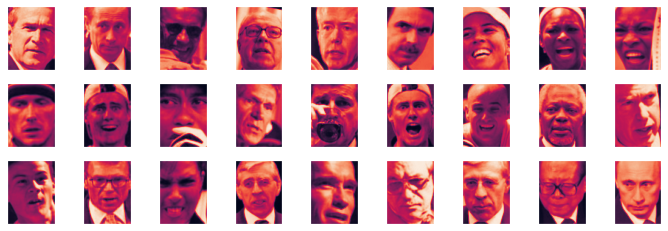

In [66]:
'''잡음 포인트와 클러스터에 속한 포인트 수를 센다.  
   bincount는 음수를 받을 수 없어서 labels에 1을 더한다.    
   반환값의 첫 번쨰 원소는 잡음 포인트의 수이다.'''
print('num of points per cluster:{}'.format(np.bincount(labels+1)))

# 이상치 검출(outlier detection)
noise = X_people[labels==-1]
f,ax = plt.subplots(3,9, figsize=(12,4),
                    subplot_kw={'xticks':(), 'yticks':()})
for image, ax in zip(noise, ax.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

In [62]:
# eps에 따른 클러스터의 수와 잡음 개수

for eps in range(1,15,2):
    print('\neps={}'.format(eps))
    dbscan=DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print('num of clusters:{}'.format(len(np.unique(labels))))
    print('size of clusters:{}'.format(np.bincount(labels+1)))


eps=1
num of clusters:1
size of clusters:[2063]

eps=3
num of clusters:1
size of clusters:[2063]

eps=5
num of clusters:1
size of clusters:[2063]

eps=7
num of clusters:14
size of clusters:[2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
num of clusters:4
size of clusters:[1307  750    3    3]

eps=11
num of clusters:2
size of clusters:[ 413 1650]

eps=13
num of clusters:2
size of clusters:[ 120 1943]


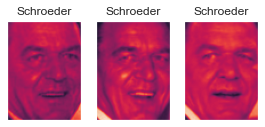

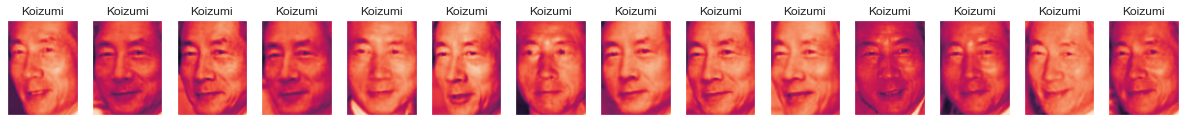

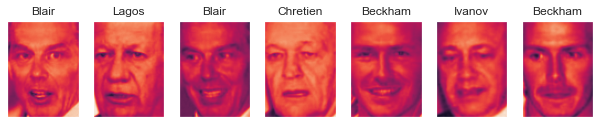

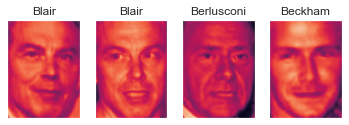

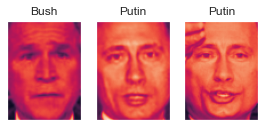

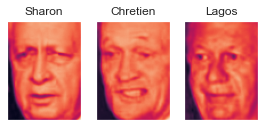

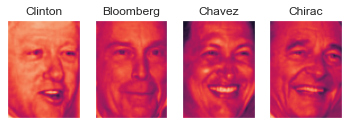

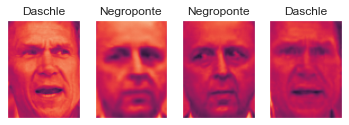

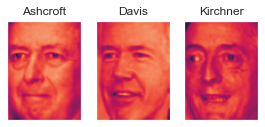

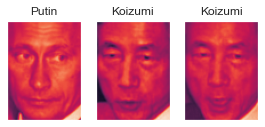

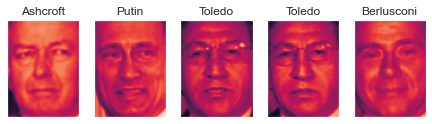

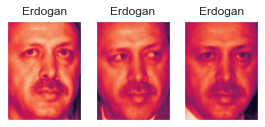

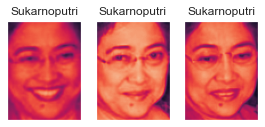

In [59]:
# eps=7 클러스터 시각화하기

dbscan = DBSCAN(eps=7, min_samples=3)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels)+1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, ax = plt.subplots(1, n_images, figsize=(n_images*1.5, 4),
                            subplot_kw={'xticks':(), 'yticks':()})
    for image, label, ax in zip(X_people[mask], y_people[mask], ax):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

##### KMeans

In [70]:
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print('size of clusters:{}'.format(np.bincount(labels_km)))

size of clusters:[155 175 238  75 358 257  91 219 323 172]


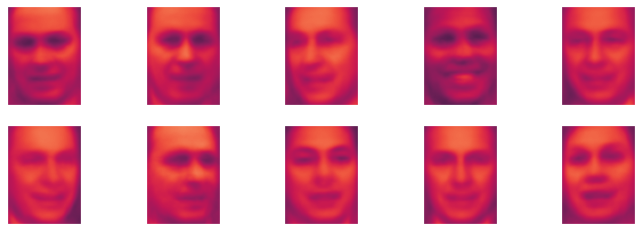

In [74]:
# KMeans(n_c=10)의 클러스터 중심

f, ax = plt.subplots(2,5, figsize=(12,4), subplot_kw={'xticks':(), 'yticks':()})
for center, ax in zip(km.cluster_centers_, ax.ravel()):
    # center도 100개의 주성분을 특성으로 갖는다. 시각화를 위해 원본 특성 공간으로 되돌린다.
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1)

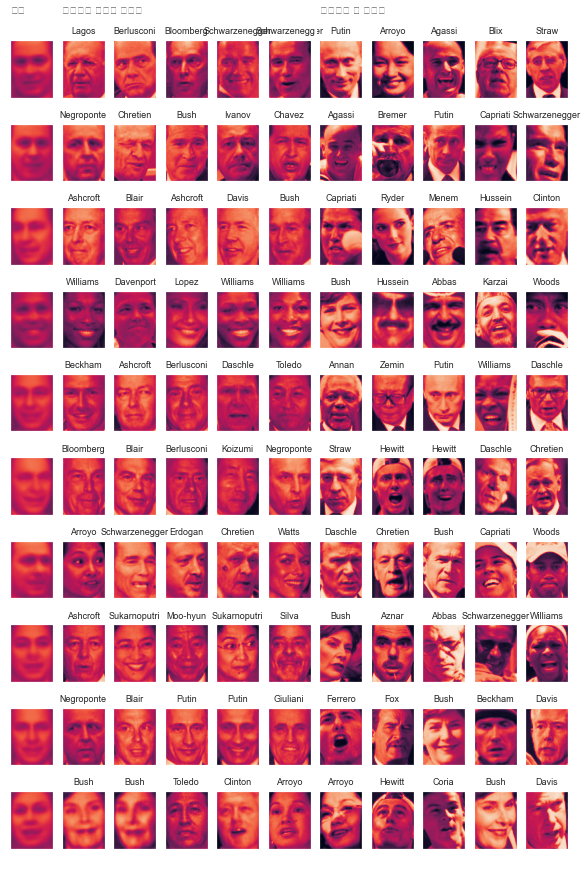

In [75]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people, y_people, people.target_names)

##### AgglomerativeClustering

In [78]:
agg = AgglomerativeClustering(n_clusters=10)
labels_agg = agg.fit_predict(X_pca)
print('size of clusters:{}'.format(np.bincount(label_agg)))

# ARI로 KMeans와 Agg가 만든 클러스터가 비슷한지 확인하기
print('ARI:{:.2f}'.format(adjusted_rand_score(labels_agg, labels_km)))

size of clusters:[169 660 144 329 217  85  18 261  31 149]


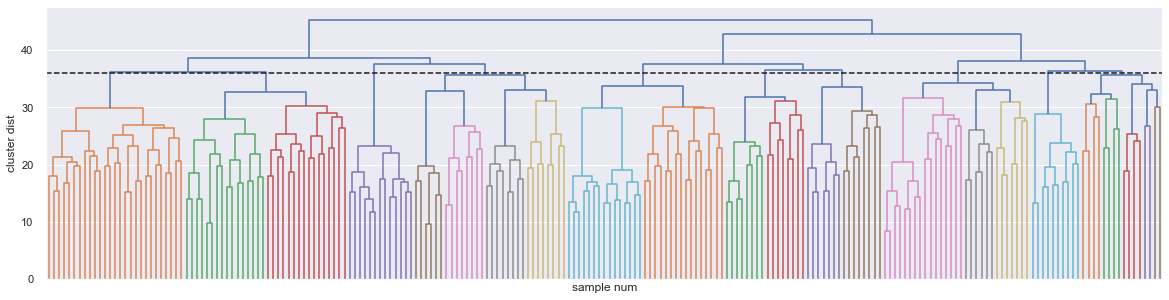

In [87]:
# 덴드로그램 그리기
linkage_array = ward(X_pca)

# 클러스터 사이의 거리가 담겨있는 linkage_array로 덴드로그램을 그린다.
plt.figure(figsize=(20,5))
# dendrogram 함수의 p 매개변수는 truncate_mode='level'일 때 트리의 최대 깊이를 지정한다.
dendrogram(linkage_array, truncate_mode='level', p=7, no_labels=True)
plt.xlabel('sample num')
plt.ylabel('cluster dist')
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [36,36], '--', c='k')


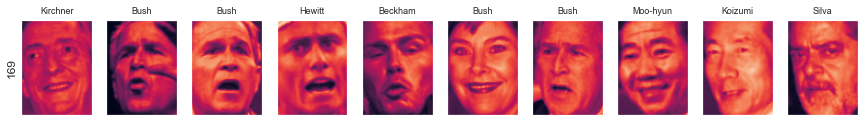

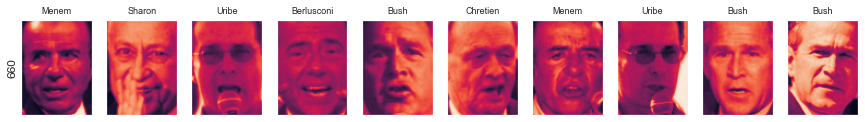

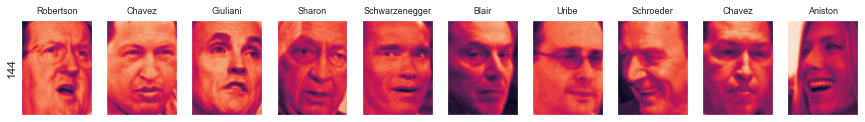

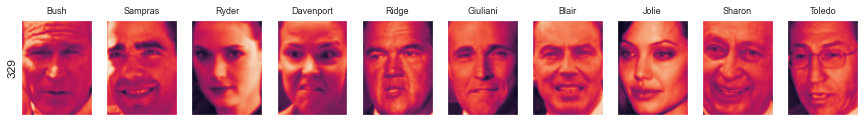

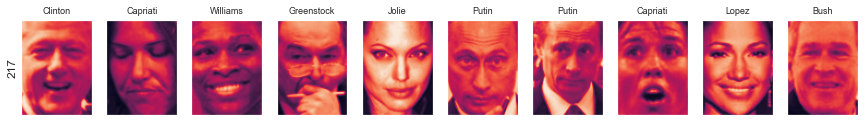

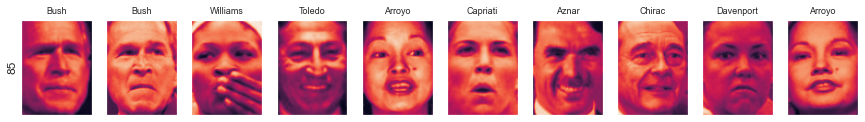

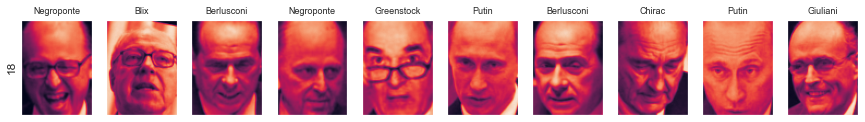

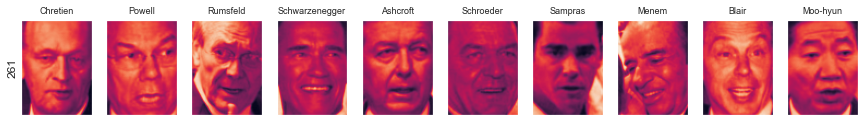

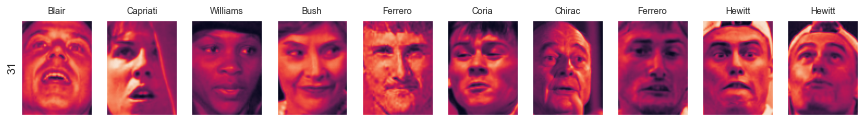

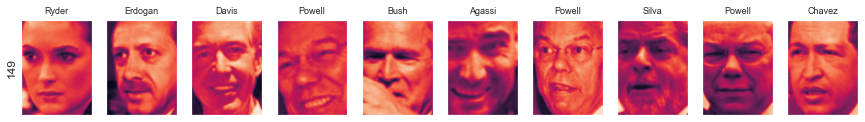

In [93]:
# 그림으로 나타내기

n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, ax = plt.subplots(1,10, figsize=(15,8),
                            subplot_kw={'xticks':(), 'yticks':()})
    ax[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                      labels_agg[mask], ax):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
                    fontdict={'fontsize':9})
